<a href="https://colab.research.google.com/github/JoeDoyle12/SportsAnalytics/blob/main/Consistency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pip install nba_api

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.7/261.7 kB 1.3 MB/s eta 0:00:00


In [3]:
from nba_api.stats.static import teams
from nba_api.stats.static import players as pl
from nba_api.stats.endpoints import commonteamroster, playergamelog, leagueleaders, commonplayerinfo
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [4]:
nba_teams = teams.get_teams()
# Select the dictionary for the Knicks, which contains their team ID
knicks = [team for team in nba_teams if team['abbreviation'] == 'NYK'][0]
knicks_id = knicks['id']
# players = commonteamroster.CommonTeamRoster(team_id=knicks_id).get_data_frames()[0]
# players
pl = leagueleaders.LeagueLeaders().get_data_frames()[0]
players = [(pl.PLAYER_ID[p], pl.PLAYER[p]) for p in pl.index][0:10]
players

[(201142, 'Kevin Durant'),
 (1629029, 'Luka Doncic'),
 (203999, 'Nikola Jokic'),
 (203954, 'Joel Embiid'),
 (201939, 'Stephen Curry'),
 (203507, 'Giannis Antetokounmpo'),
 (1628369, 'Jayson Tatum'),
 (1628983, 'Shai Gilgeous-Alexander'),
 (1630162, 'Anthony Edwards'),
 (1630178, 'Tyrese Maxey')]

In [5]:
stats = ['PTS', 'REB', 'FG_PCT', 'AST']
dic = {'PLAYER_ID': [], 'POS': [], 'NAME': [], 'GP': []}

for s in stats:
  dic['AVG_' + s] = []
  dic['CONSIS_' + s] = []

consistency = pd.DataFrame(dic)

for (id, name) in players:

  games = playergamelog.PlayerGameLog(player_id=id, timeout=60).get_data_frames()[0]
  pos = commonplayerinfo.CommonPlayerInfo(player_id=id).get_data_frames()[0]['POSITION'][0].split('-')[0]

  if len(games) == 0:
    continue
  d = {'PLAYER_ID': id, 'POS': pos, 'NAME': name,'GP': len(games)}
  for s in stats:
    d['AVG_' + s] = sum(games[s]) / len(games)
    if d['AVG_' + s] == 0:
      d['CONSIS_' + s] = 100
    else:
      d['CONSIS_' + s] = sum([abs(d['AVG_' + s] - pt) ** 2 for pt in games[s] if (pt < d['AVG_' + s])]) / (d['GP'] * d['AVG_' + s] ** 2) * 100

  consistency = pd.concat([pd.DataFrame([d]), consistency], ignore_index=True)
consistency

,PLAYER_ID,POS,NAME,GP,AVG_PTS,CONSIS_PTS,AVG_REB,CONSIS_REB,AVG_FG_PCT,CONSIS_FG_PCT,AVG_AST,CONSIS_AST
0,1630178.0,Guard,Tyrese Maxey,15.0,26.266667,2.952021,4.733333,12.051842,0.455200,0.962709,7.066667,5.629524
1,1630162.0,Guard,Anthony Edwards,15.0,26.733333,3.079915,6.000000,10.925926,0.461933,2.649627,5.133333,9.632878
2,1628983.0,Guard,Shai Gilgeous-Alexander,14.0,30.357143,5.460326,6.142857,6.733369,0.536429,6.305316,6.285714,4.420012
3,1628369.0,Forward,Jayson Tatum,16.0,27.750000,3.209967,8.875000,5.286649,0.496125,1.630934,4.062500,8.062130
4,203507.0,Forward,Giannis Antetokounmpo,15.0,29.666667,5.911711,10.266667,4.016135,0.586667,2.549879,4.533333,10.059112
5,201939.0,Guard,Stephen Curry,15.0,29.733333,2.835100,4.600000,6.792691,0.486200,2.016149,3.933333,10.152255
6,203954.0,Center,Joel Embiid,14.0,31.928571,1.962052,11.285714,2.747957,0.495786,1.221450,6.142857,4.867496
7,203999.0,Center,Nikola Jokic,16.0,28.187500,4.142802,13.500000,3.840878,0.581187,1.918428,8.875000,6.931908
8,1629029.0,Forward,Luka Doncic,15.0,30.533333,3.426295,8.266667,9.283732,0.483800,2.814335,8.066667,4.880359
9,201142.0,Forward,Kevin Durant,15.0,31.400000,2.044978,7.066667,7.497923,0.544933,2.373705,5.466667,13.104303


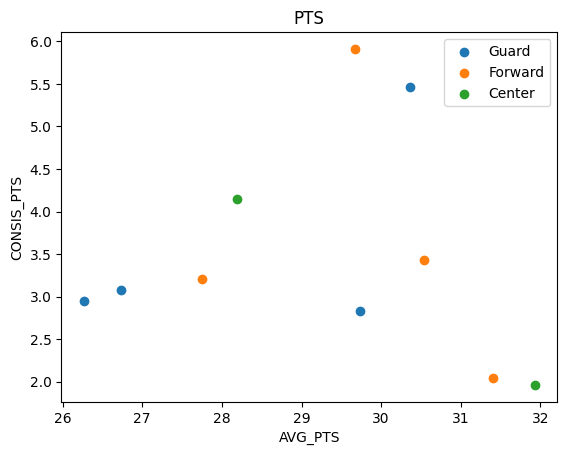

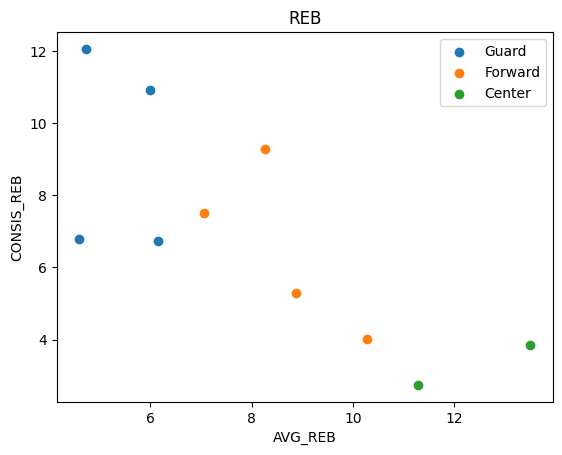

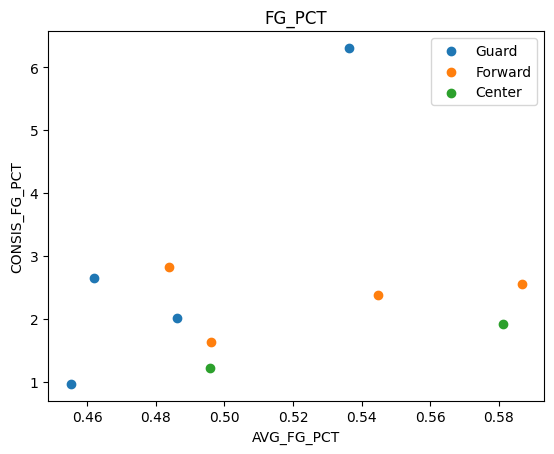

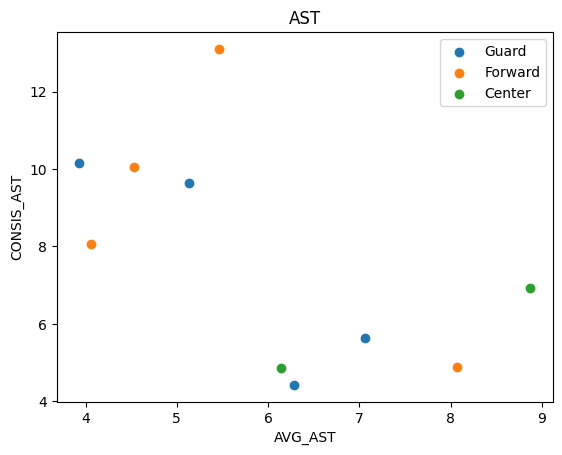

In [6]:
for s in stats:
  # print([consistency['AVG_' + s][c] for c in range(len(consistency)) if consistency[]])
  for p in ['G', 'F', 'C']:
    avg = np.array([consistency['AVG_' + s][c] for c in consistency.index if consistency['POS'][c][0] == p])
    consis = np.array([consistency['CONSIS_' + s][c] for c in consistency.index if consistency['POS'][c][0] == p])
    # print(avg, p, s)
    plt.scatter(avg, consis)

  plt.xlabel(f"AVG_{s}")
  plt.ylabel(f"CONSIS_{s}")
  plt.title(s)

  # h, l = plt.get_legend_handles_labels()
  # print(h, l)
  plt.legend(['Guard', 'Forward', 'Center'])
  plt.show()